In [33]:
import os
import torch
from torchvision import datasets, transforms, models, tv_tensors
import clip
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)
print(np.__version__)

2.2.2
1.26.4


In [17]:
labels = ['no diabetic retinopathy', 
          'mild diabetic retinopathy',
         'moderate diabetic retinopathy',
         'severe diabetic retinopathy',
         'proliferative diabetic retinopathy']

In [18]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax

In [19]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:45<00:00, 7.84MiB/s]


In [16]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x11e442200>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [26]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [61]:
train = datasets.ImageFolder('./APTOS2019/train', transform=preprocess)

In [62]:
dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)

In [63]:
images, y = next(iter(dataloader))

In [64]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in labels]).to(device)

In [65]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(images[0].unsqueeze(0))
    text_features = model.encode_text(text_inputs)

In [69]:
# Pick the top n most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(len(labels))

In [70]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

moderate diabetic retinopathy: 23.38%
proliferative diabetic retinopathy: 22.54%
mild diabetic retinopathy: 22.51%
no diabetic retinopathy: 16.24%
severe diabetic retinopathy: 15.34%


<Axes: title={'center': 'moderate diabetic retinopathy'}>

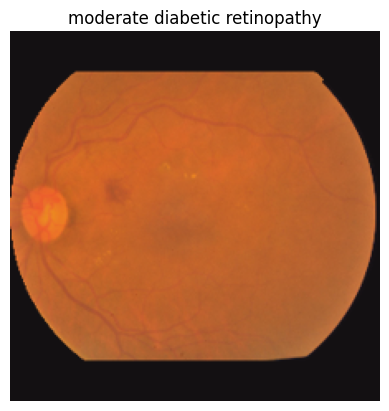

In [71]:
imshow(images[0], title=f'{labels[int(y[0])]}', normalize=True)